<a href="https://colab.research.google.com/github/Aswani-ReddyKV/Melanoma_Detection/blob/main/aswani_reddy_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [75]:
# import pathlib
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import os
# from glob import glob
# import PIL
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd
%matplotlib inline

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
rootfolder = '/content/drive/MyDrive/Colab Notebooks/SkinCancer_Data'
train_dir = pathlib.Path(rootfolder + '/Train')
test_dir = pathlib.Path(rootfolder + '/Test')

In [79]:
#Get the number of images present in Train directory
train_img_count = len(list(train_dir.glob('*/*.jpg')))
print("Total Images(Train):",train_img_count)

Total Images(Train): 2239


In [80]:
#Get the number of images present in Test directory
test_img_count = len(list(test_dir.glob('*/*.jpg')))
print("Total Images(Test):",test_img_count)

Total Images(Test): 118


Define parameters for loader

In [81]:
# Batch size
batch_size = 32
# image height
img_height = 180
# image width
img_width = 180

Use 80% of the images for training and 20% for validation.
Creating two separate sets for Train and Validation.

In [82]:
# split dataset for train
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [83]:
# split dataset for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [84]:
#get class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [85]:
len(class_names)

9

In [86]:
datalist =[]
for c in class_names:
  lst = os.listdir(pathlib.Path(train_dir / c)) # use / to join paths
  number_files = len(lst)
  datalist.append([c, number_files])
df = pd.DataFrame(datalist, columns=['Class', 'Count'])

<ipython-input-87-976abc20856a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Count", y="Class", data=df, palette='copper_r')


<Axes: xlabel='Count', ylabel='Class'>

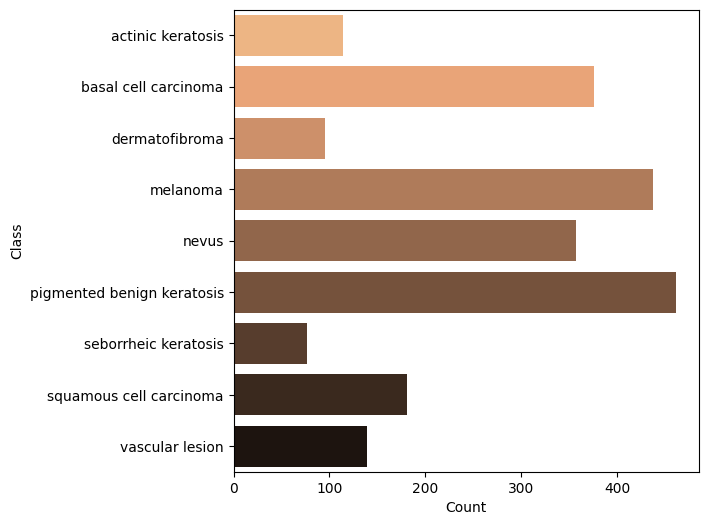

In [87]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.barplot(x="Count", y="Class", data=df, palette='copper_r')

In [88]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [89]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
####Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [90]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
# model.add(Rescaling(1./255, input_shape=(180, 180, 3)))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# model.add(Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))


model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [91]:
# compile
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [92]:
# View the summary of all layers
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 89, 89, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 89, 89, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 87, 87, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 29,043,105 (110.79 MB)

 Trainable params: 29,042,465 (110.79 MB)

 Non-trainable params: 640 (2.50 KB)

### Train the model

In [93]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 0.1869 - loss: -49195.8047 - val_accuracy: 0.1499 - val_loss: 2307.2158
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.1554 - loss: -676471.0625 - val_accuracy: 0.1499 - val_loss: 5756.9775
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1717 - loss: -2566640.2500 - val_accuracy: 0.1499 - val_loss: 927.6860
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1873 - loss: -6512753.5000 - val_accuracy: 0.1499 - val_loss: -983468.1250
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1504 - loss: -13550614.0000 - val_accuracy: 0.1499 - val_loss: -829728.5625
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.1786 - loss: -23226140.0000 - val_accuracy: 0.1499 - val_loss: -11423972.0000
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1672 - loss: -38378980.0000 - val_accuracy: 0.1499 - val_loss: -28728210.0000
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━

### Visualizing training results

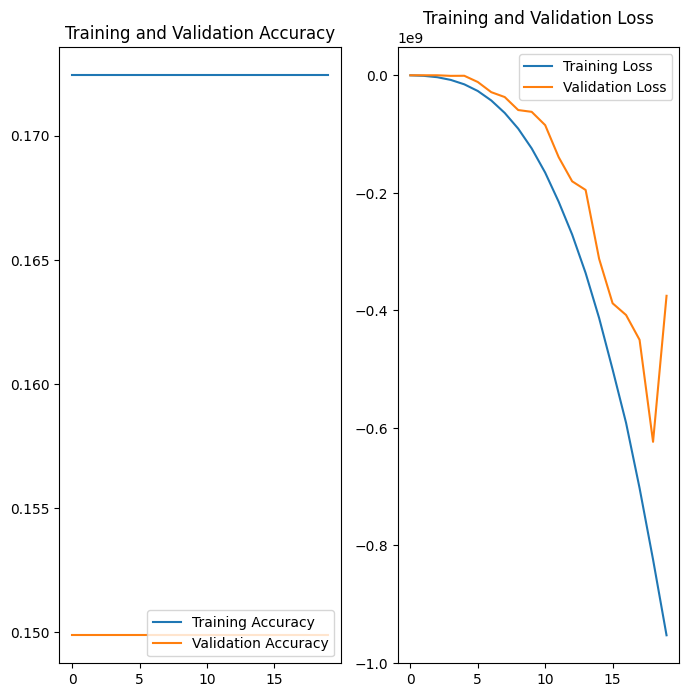

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()